## Lab 4 Convolution

### Predicting Digits

Notes on M.L. Libraries

Potential libraries to use:

Theano

Tensorflow, Google

    could remake this in notebook for assignment:
    
    https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_deep.py
    
Torch/Pytorch, Facebook

CNTK(gluon)

Keras

    pip install --update keras
    
(more options in c++/cuda)

For this project I will be using Keras for data training. For a decent introduction to keras see: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

https://github.com/yashk2810/Visualization-of-Convolutional-Layers/blob/master/Visualizing%20Filters%20Python3%20Theano%20Backend.ipynb

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data() 
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
num_train, height, width, depth = X_train.shape # there are 50000 training examples
num_test = X_test.shape[0] # there are 10000 test examples
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train/= 255 # Normalise data to [0, 1] range
X_test/= 255 # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

inp = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end

print(X_test.shape)
print(X_train.shape)

Using TensorFlow backend.


(10000, 28, 28, 1)
(60000, 28, 28, 1)


In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def print_data(testx, testy, m):#m for model
    score = m.evaluate(testx, testy, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])#print accuracy    
    predictions = m.predict_classes(testx)
    Y_t = np.argmax(testy, axis=1)
    print(precision_recall_fscore_support(Y_t, predictions))
    print("Classification")
    print(classification_report(Y_t, predictions))
    print("Confusion Matrix")
    print(confusion_matrix(Y_t, predictions))

In [8]:
batch_size = 28 # in each iteration, we consider 28 training examples at once
num_epochs = 15 # we iterate 15 times over the entire training set
k_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons
pad='same'

m1 = Sequential()
m1.add(Conv2D(conv_depth_1, (k_size, k_size), activation='relu', input_shape=(28,28,1)))
BatchNormalization(axis=-1)
m1.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

m1.add(Flatten())
m1.add(Dense(conv_depth_2, activation='relu'))#neural network layer
BatchNormalization()
m1.add(Dense(num_classes, activation='softmax'))
m1.summary()
m1.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
m1.fit(X_train, Y_train, batch_size=batch_size,
          epochs=num_epochs, verbose=1,
          validation_data=(X_test, Y_test))#removed callbacks=[history]

print_data(X_test, Y_test, m1)
#unused code from an example i found
## Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
#conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
#conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
#pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
#drop_1 = Dropout(drop_prob_1)(pool_1)
## Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
#conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
#conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
#pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
#drop_2 = Dropout(drop_prob_1)(pool_2)
## Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
#flat = Flatten()(drop_2)
#hidden = Dense(hidden_size, activation='relu')(flat)
#drop_3 = Dropout(drop_prob_2)(hidden)
#out = Dense(num_classes, activation='softmax')(drop_3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                346176    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 40s 663us/step - loss: 0.159

### Results of Run

For this model I used once convolutional layer with 32 kernels, and one fully connected neural network layer that fed into a softmax output layer. The model came up with a 98.48% accuracy. The model was most often wrong when it came to the digit 9 being predicted as a 4, which to be honest seems like an almost human mistake.

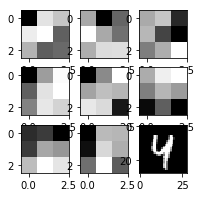

<class 'numpy.ndarray'>
(3, 3, 1, 32)
<class 'numpy.ndarray'>
(32,)
[[[[-0.56428576  0.0606623   0.14210002 -0.91838527 -0.76717526  0.04474824
    -0.54339558 -0.42050293  0.16667008  0.08130168 -0.7087428  -0.27193767
    -0.34644228  0.16770074  0.34822068  0.01211134  0.04579123  0.28536919
     0.27042586 -0.90233946 -0.16886547  0.3346729   0.167155    0.11133454
    -0.36250833  0.22236921 -0.10721269 -0.02601752 -0.28484732  0.02436283
    -0.50142694  0.12491214]]

  [[ 0.22786918 -0.53668433  0.21655396 -0.16611862 -0.14533451  0.31253743
    -0.46471968  0.13700271  0.35569358  0.39885125  0.19004089  0.11070897
    -0.17449316  0.21507016 -0.20264648 -0.0229107   0.06646062 -0.03007865
     0.19378439 -0.66733915  0.33019742 -0.02420424  0.11714293  0.42346251
    -0.25895736  0.26658624 -0.34046733 -0.01786722  0.1207715   0.27625337
    -0.36503097 -0.08176529]]

  [[ 0.11990088 -0.17478669 -0.20317233  0.28286347  0.38197744  0.3808226
    -0.76372892  0.12546732 -0.1546

In [42]:
#attempt at printing convolved image
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(X_test[42]), cmap='gray')
plt.show()
weights, biases = m1.layers[0].get_weights()#two tensors
print(type(weights))
print(weights.shape)
print(type(weights))
print(biases.shape)
#plt.imshow(weights[:, :, 0, 0], cmap='gray')
#plt.show()
fig = plt.figure(figsize=(3,3))
for i in range(0, 9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(weights[:, :, 0, i], cmap='gray')
    
print(weights)

### Thoughts on Kernel Patterns

What immidiatly sticks out to me is that none of the kernels that i saw were heavily weighted for the center square, usually the corners had the highest weight. From what I remember of image processint this seems like it is valueing edge detection within the model.

In [25]:
#function for creating simple model
#def train_cnn(xt, yt, xtrain, ytrain, c_depth, kern_sizes, padding, layers):# padding='valid' | 'same' and activation='relu'
#    model = Sequential()
#    input_shape = Input(shape=(height, width, depth))
#    model.add(Conv2D(32, (kern_sizes[0], kern_sizes[0]), padding, activation='relu',
#                 input_shape=input_shape))

batch_size = 28 # in each iteration, we consider 28 training examples at once
num_epochs = 15 # we iterate 200 times over the entire training set
k_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons
pad='same'

model = Sequential()
model.add(Conv2D(conv_depth_1, (k_size, k_size), activation='relu', input_shape=(28,28,1)))#convolution one
BatchNormalization(axis=-1)
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Conv2D(conv_depth_2, (k_size, k_size), activation='relu', input_shape=(28,28,1)))#convolution 2
BatchNormalization(axis=-1)

model.add(Flatten())
model.add(Dense(hidden_size, activation='relu'))#neural network layer
BatchNormalization()
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=batch_size,
          epochs=num_epochs, verbose=1,
          validation_data=(X_test, Y_test))#removed callbacks=[history]
print_data(X_test, Y_test, model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               3965440   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 3,989,386
Trainable params: 3,989,386
Non-trainable params: 0
_________________________________________________________________


### Final Thoughts

First of all 15 Epochs ended up being far to many rounds for (for my computer). I was rather astounded by how accurate this model was with digit prediction. 

### Future Plans

In the future I would like to experiment more with number, size and type of layers within the model. Are there things that could be done to help the model improve it's accuracy when it comes to things like predicting nines as fours. 